# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

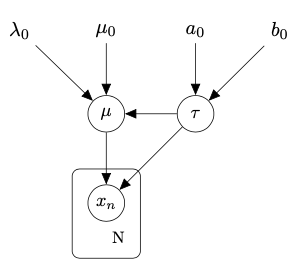

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [17]:
import numpy as np
def generate_data(mu, tau, N):
  # Insert your code here
  D = np.random.normal(mu, tau, N)

  return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



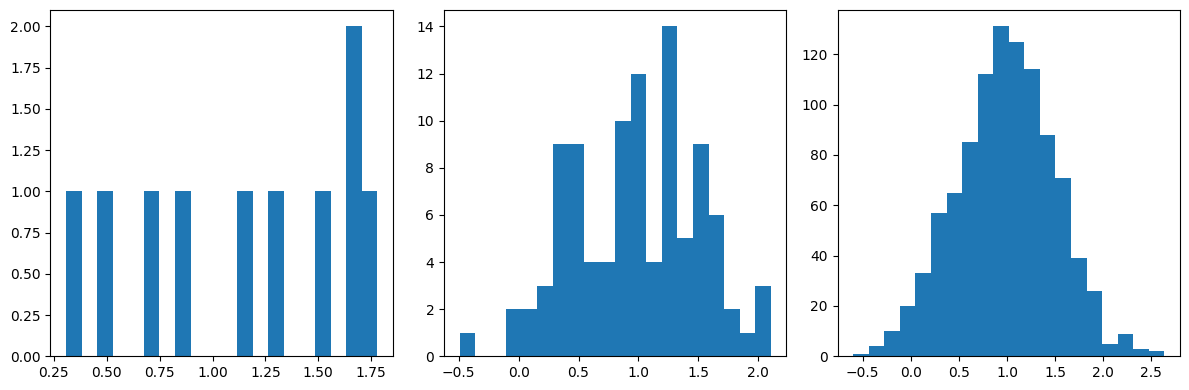

In [18]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(dataset_1, bins=20)
axs[1].hist(dataset_2, bins=20)
axs[2].hist(dataset_3, bins=20)
plt.tight_layout()
plt.savefig('12_data.png')
plt.show()

### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [19]:
def ML_est(data):
    # insert your code
    N = len(data)
    x_mean = np.mean(data)
    x_var = np.var(data, ddof=1)

    tau_ml = 1 / (N * x_var)
    mu_ml = x_mean

    return mu_ml, tau_ml

### ***Question 1.3.14:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [20]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
    # your implementation
    x_mean = np.mean(D)
    N = len(D)

    mu_prime = (lambda_0 * mu_0 + N * x_mean) / (lambda_0 + N)
    lambda_prime = lambda_0 + N
    a_prime = a_0 + N / 2
    b_prime = b_0 + 1 / 2 * (np.sum((D - x_mean)**2) +
                             lambda_0 * mu_0**2 - lambda_prime * mu_prime**2)

    exact_post_distribution = (mu_prime, lambda_prime, a_prime, b_prime)

    return exact_post_distribution

### ***Question 1.3.15:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [21]:
# prior parameters
mu_0 = 0 
lambda_0 = 1
a_0 = 1
b_0 = 1

Continue with a helper function that computes ELBO:


In [22]:
from scipy.stats import gamma, norm
def compute_elbo (D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
  # given the prior and posterior parameters together with the data,
  # compute ELBO here
  N = len(D)
  # to implement
  return elbo


Now, implement the CAVI algorithm:

In [23]:
def CAVI(D, a_0, b_0, mu_0, lambda_0):
  # make an initial guess for the expected value of tau
  initial_guess_exp_tau = 1

  N = len(D)
  x_mean = np.mean(D)
  x_2_sum = np.sum(D**2)

  # Constants
  a_N = a_0 + N / 2
  mu_N = (lambda_0 * mu_0 + N * x_mean) / (lambda_0 + N)
  E_mu = mu_N
  
  # Variational parameters
  b_N = b_0
  lambda_N = lambda_0

  # ELBO
  elbos = []

  # CAVI iterations ...
  for i in range(100):
    # update the values for the variational parameters
    E_tau = a_N / b_N 
    E_mu_2 = 1 / lambda_N + mu_N**2

    lambda_N = (lambda_0 + N) * E_tau
    b_N = b_0 + 1 / 2 * (x_2_sum + N*E_mu_2 - 2*N*E_mu*x_mean + lambda_0*(E_mu_2 - 2*E_mu*mu_0 + mu_0**2))
    # save ELBO for each iteration, plot them afterwards to show convergence
    #elbos.append(compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N))

  return a_N, b_N, mu_N, lambda_N, elbos

### ***Question 1.3.15:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



In [24]:
# Insert your main code here


# Example flow for dataset_2:
  ##  mu_ml, tau_ml = ML_est(dataset_2)
  ##  a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  plot elbos, show convergence
  ##  exact_post_dist = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)
  ##  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot

mu_ml, tau_ml = ML_est(dataset_2)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset_2, a_0, b_0, mu_0, lambda_0)
exact_post_dist = compute_exact_posterior(dataset_2, a_0, b_0, mu_0, lambda_0)

print('mu_ml: ', mu_ml)
print('tau_ml: ', tau_ml)
print('a_N: ', a_N)
print('b_N: ', b_N)
print('mu_N: ', mu_N)
print('lambda_N: ', lambda_N)
print('exact_post_dist: ', exact_post_dist)


mu_ml:  0.9824560280705554
tau_ml:  0.03642663412471725
a_N:  51.0
b_N:  15.21596570887011
mu_N:  0.9727287406639163
lambda_N:  338.5259995030902
exact_post_dist:  (0.9727287406639163, 101, 51.0, -33.19420278013917)
